In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

from sklearn.manifold import TSNE
import copy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A,D=loadgraph()
        elif recon:
            E1,E2,A,D=loadgraph(recon=True, train=False,run=run,t_r=j)
            #print('recon')
        else:
            E1,E2,A,D=loadgraph(train=False)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        d_batch.append(D)
        
        
    #print('src_batch',src1_batch[3])
    #print('src2_batch',src2_batch[3])
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    
    
    #print('src1',src1_batch[:,0,:],src1_batch[:,0,:].size())
    #print('src2',src2_batch[:,0,:],src2_batch[:,0,:].size())
    #print('y',y_batch)
    ##
    return src1_batch, src2_batch,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,3) #!!!!!!!!!!##100 total data size
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(1,3) #!!!!!!!!
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask


def train_easy(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    model.train()
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        print(i)
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src1, src2, y = collate_fn(10,-100)
        
        #print('src_batch',src1)
        #print('src_batch s',src1.size())
        
        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output1,output2 = model(src1,src2,src_padding_mask1,src_padding_mask2)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        #print('out1',output1,output1.size())
        #print('out2',output2,output2.size())
        
        

 
        #print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = loss_function(output1, src1)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        i=i+1
        
        '''
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(easy=True)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error
    '''
        
        
class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    #print(Ad[0],y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)


def train_epoch_post_process(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)
    
    Ad = complete_postprocess(Ad,d,0.01)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    print(Ad[0])
    print(y[0])
    #print('l',loss)
    #print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)



class Loss():
    def __init__(self,pen,tra_to_tens=False):
        self.pen=pen
        self.trans=tra_to_tens
        
    def loss (self,Ad,y):
        convert_tensor = transforms.ToTensor()
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            if self.trans:
                Ad[i]=convert_tensor(Ad[i])[0]
            #print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        if self.trans:
            loss = Variable(loss, requires_grad = True)
        return loss
    


def evaluate(model,loss_fn):
    #model.eval()
    losses = 0

    src1, src2, y,d = collate_fn(31,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    try:
        Ad,out1,out2,out_dec1,src1_t1,src2_t2 = model(src1,src2,src_padding_mask1,src_padding_mask2)
    except:    
        Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)


def postprocess(A):
    pp_A=[]
    for i in range(len(A)):
        ind=torch.argmax(A[i], dim=0)
        B=np.zeros(A[i].shape)
        for j in range(len(ind)):
            B[ind[j],j]=1
        pp_A.append(B)
    return pp_A

def square(m):
    return m.shape[0] == m.shape[1]


def postprocess_2(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2)  
        
    return pp_A



def postprocess_3(Ad):
    pp_A=[]
    
    row_ind, col_ind = linear_sum_assignment(1-Ad[0])
    
    print(1-Ad[0])
    print(row_ind, col_ind)
    
    z=np.zeros(Ad[0].shape)


    for i,j in zip(row_ind, col_ind):
        z[i,j]=1
    
    
    print(z)
    '''
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h])

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2) 
    '''
        
    return pp_A








def postprocess_linAss(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
        else:
            f=Ad[h].detach().numpy()
            l=np.ones(len(f))*2
            l=l.astype(int)
            
            
            f2=np.repeat(f, l, axis=0)
            row_ind, col_ind = linear_sum_assignment(1-f)
            z=np.zeros(f.shape)
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1

            f2[0::2, :] = z[:] 

            row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


            z3=np.zeros(f2.shape)


            for i,j in zip(row_ind_f, col_ind_f):
                z3[i,j]=1

            f_add = z3[0::2, :] + z3[1::2, :]
            
            pp_A.append(f_add)

        
    return pp_A





def postprocess_MinCostAss(Ad,a):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = np.append(start_nodes,0)
        start_nodes = [int(x) for x in start_nodes ]
        #print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = np.append(end_nodes,si_e[-1])
        end_nodes = [int(x) for x in end_nodes ]
        #print(end_nodes)
        
        
        tasks = np.max([right_n,left_n])
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = np.append(capacities,tasks)
        capacities = [int(x) for x in capacities]
        #print(capacities)
        
        '''
        c_A[0]=c_A[0]/c_A[0,0]
        c_A[0]=c_A[0]/(1.01*np.max(c_A[0]))
        c_A[:,0]=c_A[:,0]/c_A[0,0]
        c_A[:,0]=c_A[:,0]/(1.01*np.max(c_A[:,0]))
        '''
        
        #print(c_A)
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
        costs = np.append(costs,a*np.mean(c))                            
        costs = [int(x) for x in costs]
                                    
        #print(costs)
        
        source = 0
        sink = left_n+right_n+1
        
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-(tasks+left_n))
        
        supplies = [int(x) for x in supplies]
        #print(supplies)
        #print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
             
            
            #print('z_orig',z)
            s=np.sum(z,axis=1)
            for e in range(len(s)):
                if s[e]>1 and e!=0:
                    z[e,0]=0
            #print('z_bg_cor',z)      
            if (~z.any(axis=0)).any():
                z_col_ind=np.where(~z.any(axis=0))[0]
                z[:,z_col_ind]=c_A[:,z_col_ind]
                #print('---------z_0_col',z)
                z=postprocess_MinCostAss(np.array([z]),2*a)[0]
                #print('z_0_col_after',z)

                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

      
'''

    start_nodes = np.zeros(c_A.size(0)) + [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3
    ] + [4, 5, 6, 7]
    end_nodes = [1, 2, 3] + [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7] + [8,8,8,8]
    capacities = [2, 2, 2] + [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ] + [2, 2, 2, 2]
    costs = (
        [0, 0, 0] +
        c +
        [0, 0, 0 ,0])

    source = 0
    sink = 8
    tasks = 4
    supplies = [tasks, 0, 0, 0, 0, 0, 0, 0, -tasks]

    # Add each arc.
    for i in range(len(start_nodes)):
        smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        smcf.set_node_supply(i, supplies[i])

    # Find the minimum cost flow between node 0 and node 10.
    status = smcf.solve()

    if status == smcf.OPTIMAL:
        print('Total cost = ', smcf.optimal_cost())
        print()
        for arc in range(smcf.num_arcs()):
            # Can ignore arcs leading out of source or into sink.
            if smcf.tail(arc) != source and smcf.head(arc) != sink:

                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if smcf.flow(arc) > 0:
                    print('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                          (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')
            pp_A.append(f_add)

        
    return pp_A

'''

def make_reconstructed_edgelist(A,run):
    
    e_start=[2,3,4]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        print('M0',M)
        X=M[0][1:]
        M=M[1:,1:]
        #print('M1',M)
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                if M[z,j]!=0:
                    #print(z,e_start)
                    e1.append(int(e_start[z]))
                    #print('e',e_mid)
                    e2.append(int(e_mid[j]))
                if z==0 and X[j]!=0:
                    e1.append(int(1))
                    e2.append(int(e_mid[j]))
                    
        
        e_start=e_mid
        #print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d,a):
    
    Ad_n = []
    #Ad_n=copy.deepcopy(Ad)
    
    for h in range(len(Ad)):
        
        A_t,ill_flag=treshold(Ad[h],t=0.5)
        
        #print('ill_flag',ill_flag)
        #print(Ad[h],A_t)
        if ill_flag==True:
            Ad[h]=np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy())
            A_t = postprocess_MinCostAss(np.array([Ad[h]]),a)[0]
            
        #print(Ad[h],A_t)
        Ad_n.append(A_t)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad_n

def treshold(matrix, t):
    z=np.where(matrix >= t, 1, 0)
    
    ill_flag=False

      
    if (~z.any(axis=0)).any() or any(np.sum(z[:,1:], axis=0)>1):
        ill_flag=True
          
    return z,ill_flag

def err_perc(a,b):
    w=0
    s=0
    for i in range(len(a)):
        m=a[i]-b[i].detach().numpy()
        w=w+0.5*np.sum(np.abs(m))
        s=s+np.size(m)
    
    
    print('w,s',w,s)
    
    return w*100/s

In [3]:
a = np.array([[0.99, 0.87,0.05,0.08,0.77,0.11], [0.05, 0.12,0.19,0.11,0.14,0.93],[0.07, 0.12,0.45,0.89,0.23,0.05],[0.04, 0.1,0.97,0.65,0.34,0.02]])
print(a)

b = np.array([[1, 1,1,1,1,1], [1, 0.75,0.07,0.1,0.08,0.8],[1, 0.69,0.07,0.88,0.34,0.02],[1, 0.1,0.9,0.05,0.84,0.02]])
print(b)

print(np.multiply(a,b))
#print(threshold_matrix(a, 0.2))
print(a[:,1:])
print(any(np.sum(a[:,1:], axis=0)>1))
np.concatenate((a, b), axis=0)


#np.concatenate((a, b.T), axis=1)
c = np.array([[1, 0,0], [0, 1,0],[0, 0,1]])
d = np.array([[1, 0,0], [0, 0,1],[0, 0,1]])


m=c-d
print(np.sum(np.abs(m))/np.size(m))


c = torch.from_numpy(c).float()
d = torch.from_numpy(d).float()



cross_entropy_loss = nn.CrossEntropyLoss()

loss = cross_entropy_loss(c, d)

print(loss)

            


loadgraph(run=1)

#print(stop)

[[0.99 0.87 0.05 0.08 0.77 0.11]
 [0.05 0.12 0.19 0.11 0.14 0.93]
 [0.07 0.12 0.45 0.89 0.23 0.05]
 [0.04 0.1  0.97 0.65 0.34 0.02]]
[[1.   1.   1.   1.   1.   1.  ]
 [1.   0.75 0.07 0.1  0.08 0.8 ]
 [1.   0.69 0.07 0.88 0.34 0.02]
 [1.   0.1  0.9  0.05 0.84 0.02]]
[[9.900e-01 8.700e-01 5.000e-02 8.000e-02 7.700e-01 1.100e-01]
 [5.000e-02 9.000e-02 1.330e-02 1.100e-02 1.120e-02 7.440e-01]
 [7.000e-02 8.280e-02 3.150e-02 7.832e-01 7.820e-02 1.000e-03]
 [4.000e-02 1.000e-02 8.730e-01 3.250e-02 2.856e-01 4.000e-04]]
[[0.87 0.05 0.08 0.77 0.11]
 [0.12 0.19 0.11 0.14 0.93]
 [0.12 0.45 0.89 0.23 0.05]
 [0.1  0.97 0.65 0.34 0.02]]
True
0.2222222222222222
tensor(0.8848)


(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1446e-01, -4.6608e-01, -4.8747e-01,  3.9730e-01, -7.0962e-02,
           8.2392e-03,  

In [4]:
class AdjacencyTransformer_2(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 out = False, 
                 dim_feedforward: int = 512,
                 dropout: float = 0.05):
        super(AdjacencyTransformer_2, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        
        self.out=out 
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        
        #self.lin = nn.Sequential(
        #    nn.Linear(input_dim, emb_size),
        #    nn.LeakyReLU())
        
        self.lin2 = nn.Sequential(
            nn.Linear(emb_size, emb_size),
            nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        #src_t1 = self.lin(src_t1)
        #src_t2 = self.lin(src_t2)
        
        #src_t1 = self.lin2(src_t1)
        #src_t2 = self.lin2(src_t2)
        
        src1_emb = src_t1
        src2_emb = src_t2
        #print('src1',src1_emb.size())
        #print('src2',src2_emb.size())
        #print('trans_src_padd',src_padding_mask1,src_padding_mask1.size())
        out1 = self.encoder(src1_emb,src_key_padding_mask=src_padding_mask1)
        #print('out1',out1.size())
        out2 = self.encoder(src2_emb,src_key_padding_mask=src_padding_mask2)
        
        out_dec1=self.decoder(out2, out1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        #print('out_dec1',out_dec1.size())
        #out_dec1=self.lin2(out_dec1)
        #print('out_dec1b',out_dec1.size())
        #out_dec2=self.decoder(out1, out2,tgt_key_padding_mask=src_padding_mask1,memory_key_padding_mask=src_padding_mask2)
        out_dec2=out1
        #out1=torch.transpose(out1,0,1)
        #out2=torch.transpose(out2,0,1)
        #out2=torch.transpose(out2,1,2)
        
        #z=self.sig(torch.bmm(out1,out2))
        
        out_dec2=torch.transpose(out_dec2,0,1)
        out_dec1=torch.transpose(out_dec1,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        #print('z',z.size())
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        if self.out:
            return Ad,out1,out2,out_dec1,src_t1,src_t2
        else:
            return Ad


In [7]:
input_dim=3

emb_size= 60 ###!!!!24 for n2v emb
nhead= 6    ####!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer_2(num_encoder_layers, emb_size, nhead)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [11]:
from timeit import default_timer as timer
NUM_EPOCHS = 2

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')


Epoch: 1, Train loss: 4.537, Val loss: 4.300, Epoch time = 2.944s
Epoch: 2, Train loss: 4.793, Val loss: 4.380, Epoch time = 3.179s


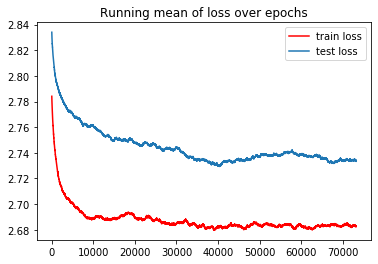

In [9]:
loss_over_time= np.loadtxt('./train_loss_AttTrack_2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_AttTrack_2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=10000
plt.plot(np.convolve(loss_over_time, np.ones(N)/N, mode='valid'),c='red',label='train loss')
plt.plot(np.convolve(test_error, np.ones(N)/N, mode='valid'),label='test loss')
plt.title('Running mean of loss over epochs')
plt.legend()

In [ ]:
a=np.linspace(0.01,1,num=1)
#a=[0.1]

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()
convert_tensor = transforms.ToTensor()
lo=[]
for k in range(len(a)):
    print(lo)
    print('k---',k)
    g=[]
    for v in range(10):
        #print('v-',v)


        src1, src2, y,d = collate_fn(1,-100,train=False)

        src1= src1.to(DEVICE)
        src2= src2.to(DEVICE)



        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)

        Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
        #print(Ad[0])

        Ad_real = complete_postprocess(Ad,d,a[k])
        #print(Ad_real[0])
        #print(y[0])
        
        Ad_real= convert_tensor(Ad_real[0])


        l = nn.CrossEntropyLoss()
        s = l(Ad_real[0], y[0])
        g.append(s)
    lo.append(np.mean(g))

plt.plot(a,lo)






#postprocess Training


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


NUM_EPOCHS=1000


transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0,tra_to_tens=True)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00001, betas=(0.9, 0.98), eps=1e-9)

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch_post_process(transformer, optimizer,loss_fn)
    end_time = timer()
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_pp.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
#torch.save(transformer.state_dict(), 'AttTrack24.pt')

In [15]:
#recon+testerror
for r in range(1,3):
    src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=r)

    #print(src1.size())
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    
    #transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
    transformer.eval()
    
    

    Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
    
    val_loss = evaluate(transformer,loss_fn)
    #print('L',val_loss)
    a=0.1
    #print(Ad)
    #pp_A = complete_postprocess(Ad,d,a)
    
    #err_p=err_perc(pp_A,y)
    #print('err',r,err_p)

#print(src1.size())

    print('y',y[6])
    print('Ad',Ad[6])
    #print('pp',pp_A[6])
    #print('d',d[6])

#for i in range(5):
#    print(pp_A[i])
    
    
    make_reconstructed_edgelist(Ad,run=r)

y tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])
Ad tensor([[1.0000, 0.9767, 0.9341, 0.9624],
        [0.9974, 0.8354, 1.0000, 0.9914],
        [0.8336, 0.0033, 0.5013, 1.0000],
        [0.9948, 1.0000, 0.9309, 0.2526]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 1.0000, 0.9999, 0.9996, 0.9997],
        [0.9512, 0.0015, 0.0032, 0.8828, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.5083, 0.9983],
        [0.9886, 0.7781, 0.9931, 1.0000, 0.8776]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 0.9993, 0.9998, 0.9990],
        [0.9998, 0.0665, 1.0000, 0.2011],
        [0.9895, 0.0675, 1.0000, 0.0112],
        [0.9939, 1.0000, 0.4625, 0.2910],
        [0.9994, 0.4460, 0.8340, 1.0000]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 0.9993, 0.9990, 1.0000],
        [0.9997, 0.0018, 1.0000, 0.9326],
        [1.0000, 0.9776, 0.1659, 1.0000],
        [0.9999, 1.0000, 0.7979, 0.0505]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 0.5916,

M0 tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9573, 0.6848, 0.9892, 0.9448, 0.9709, 0.9911, 0.9581, 0.9901, 0.9577],
        [0.8727, 0.9991, 0.9992, 0.9994, 0.9980, 0.7352, 0.9993, 0.9932, 0.9800],
        [0.2634, 0.2912, 0.8747, 0.4813, 0.5334, 0.0233, 0.1305, 0.2986, 0.0858],
        [0.7689, 0.9776, 0.9987, 0.9568, 0.9789, 0.4949, 0.9992, 0.9544, 0.7545],
        [0.9994, 1.0000, 1.0000, 1.0000, 0.9999, 0.9962, 1.0000, 1.0000, 0.9996],
        [1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9992, 0.9999, 0.9999, 0.9999],
        [0.9981, 0.9999, 1.0000, 0.9999, 1.0000, 0.9983, 0.9999, 0.9999, 0.9991],
        [0.9997, 0.9975, 0.9999, 0.9995, 0.9998, 0.9994, 0.9995, 0.9996, 0.9981]],
       grad_fn=<SliceBackward0>)
M0 tensor([[9.9998e-01, 9.9962e-01, 9.9948e-01, 9.9504e-01, 9.8278e-01, 9.9942e-01,
         9.0062e-01, 9.9975e-01, 9.7820e-01, 9.9893e-01],
        [4.5479e-03, 9.8387e-02, 6.9175e-01, 8.8422e-02, 4.9516e-03, 9.5688e-01,
  

M0 tensor([[9.6391e-01, 2.0746e-01, 2.1730e-02, 4.3149e-03, 1.6787e-02, 8.0562e-02,
         3.6234e-02, 8.8517e-03, 2.5624e-03, 1.6004e-02, 7.6176e-02, 2.5626e-03,
         1.9766e-03, 2.5321e-03, 1.3733e-02],
        [7.2832e-01, 9.9588e-01, 8.5197e-01, 2.6512e-01, 9.6763e-01, 9.9338e-01,
         9.8389e-01, 6.4606e-01, 8.2265e-01, 7.9394e-01, 9.5076e-01, 2.4657e-01,
         4.3953e-01, 3.2716e-01, 9.2935e-01],
        [1.3265e-05, 7.2153e-04, 2.4792e-04, 3.3510e-05, 1.0144e-03, 1.2772e-04,
         1.5735e-05, 1.9275e-07, 2.7102e-04, 1.6734e-06, 1.8080e-05, 3.6289e-05,
         8.3746e-04, 3.0022e-04, 2.2249e-05],
        [9.9859e-01, 9.9989e-01, 9.9934e-01, 9.9669e-01, 9.9970e-01, 9.9987e-01,
         9.9994e-01, 9.9980e-01, 9.9362e-01, 9.9987e-01, 9.9963e-01, 9.9215e-01,
         9.9200e-01, 9.8087e-01, 9.9987e-01],
        [4.3062e-05, 3.7652e-03, 1.2774e-04, 4.8326e-06, 1.2520e-03, 2.6768e-04,
         1.8172e-04, 1.3445e-06, 7.5206e-04, 6.0435e-06, 1.1650e-04, 3.7774e-05,
   

y tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]])
Ad tensor([[9.9978e-01, 5.2097e-01, 1.8662e-03, 2.2997e-02, 3.7156e-01],
        [3.6154e-02, 9.9970e-01, 1.7538e-02, 8.0026e-01, 2.0140e-05],
        [3.3709e-02, 7.2144e-01, 9.9987e-01, 9.9999e-01, 6.1700e-05],
        [9.6662e-01, 9.7686e-01, 1.0000e+00, 1.0000e+00, 4.0100e-01],
        [2.3549e-01, 5.9674e-02, 4.7967e-04, 5.7758e-04, 9.9998e-01]],
       grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 1.0000, 1.0000, 0.9998],
        [0.9999, 1.0000, 1.0000, 0.9999],
        [0.9997, 0.9987, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.9996]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 0.9996, 0.9987, 0.9999],
        [0.9999, 1.0000, 0.9985, 1.0000],
        [0.9864, 0.9982, 0.9944, 1.0000],
        [0.9138, 0.8209, 1.0000, 0.9981]], grad_fn=<SliceBackward0>)
M0 tensor([[1.0000, 0.9872, 0.9905, 0.9872, 0.9689],
        [0.

M0 tensor([[9.9983e-01, 4.7032e-01, 9.6492e-01, 2.0622e-01, 1.7346e-01, 9.8123e-01,
         5.7989e-01, 7.1439e-01, 6.9255e-01, 2.9864e-01, 2.1755e-01, 3.0590e-01],
        [8.0194e-03, 3.8054e-01, 5.4063e-05, 9.9554e-01, 1.6964e-01, 3.4805e-04,
         1.3947e-05, 9.6639e-01, 9.3929e-01, 9.9697e-01, 9.7814e-01, 9.9566e-01],
        [9.5533e-01, 9.9753e-01, 9.1047e-01, 9.9456e-01, 9.8331e-01, 9.8168e-01,
         7.5580e-01, 9.9897e-01, 9.5105e-01, 9.7234e-01, 9.7834e-01, 9.8384e-01],
        [1.8872e-01, 9.9624e-01, 8.3918e-03, 9.9970e-01, 9.9487e-01, 1.5812e-01,
         3.4860e-03, 9.9915e-01, 9.9079e-01, 9.9412e-01, 9.9971e-01, 9.9937e-01],
        [9.2145e-03, 8.2357e-01, 1.5724e-04, 8.7755e-01, 2.2234e-01, 1.8055e-03,
         2.9487e-05, 9.7385e-01, 7.5113e-01, 3.8883e-01, 9.7873e-01, 8.9305e-01],
        [5.5139e-02, 7.5691e-01, 8.0887e-05, 9.8325e-01, 3.1841e-01, 5.6903e-04,
         1.5464e-04, 9.5777e-01, 9.7692e-01, 9.7875e-01, 9.8303e-01, 9.6581e-01],
        [1.7890e-01

M0 tensor([[1.0000, 0.9990, 0.9700, 0.9905, 0.9934, 0.9963, 0.9687, 0.9868, 0.9955,
         0.9917, 0.9912, 0.9818, 0.9923],
        [0.9997, 0.9992, 1.0000, 0.9999, 0.9998, 0.9999, 1.0000, 0.9998, 0.9997,
         0.9998, 1.0000, 0.9998, 0.9997],
        [0.9982, 0.9959, 0.9998, 0.9959, 0.9997, 1.0000, 0.9999, 0.9990, 0.9995,
         0.9995, 1.0000, 0.9999, 0.9984],
        [0.0137, 0.0041, 0.0721, 0.0013, 0.0111, 0.0165, 0.1070, 0.0095, 0.0389,
         0.0043, 0.0059, 0.0051, 0.0021],
        [0.9399, 0.9215, 0.9994, 0.9071, 0.9971, 0.9945, 0.9998, 0.9852, 0.9966,
         0.9885, 0.9985, 0.9985, 0.9244],
        [0.9999, 1.0000, 1.0000, 0.9996, 0.9995, 0.9999, 1.0000, 1.0000, 0.9999,
         0.9999, 0.9999, 1.0000, 0.9999],
        [0.9999, 0.9990, 1.0000, 0.9962, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998,
         0.9998, 1.0000, 1.0000, 0.9997],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000],
        [0.54

In [ ]:
print(stop)

In [ ]:
#Umap AdjacencyTrans2


emb_size= 150 ###!!!!24 for n2v emb
nhead= 6    ###!!!! 6 for n2v emb
num_encoder_layers = 3


transformer = AdjacencyTransformer_2(num_encoder_layers, emb_size, nhead,out=True)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))


NUM_EPOCHS = 2

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_Ad2.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_Ad2.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    

    
    
    
loss_over_time= np.loadtxt('./train_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss_Ad2.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=1

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))    



In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import umap.umap_ as umap


transformer.load_state_dict(torch.load('AttTrack_2.pt',map_location=torch.device('cpu')))
transformer.eval()

run=95
t= 8
src1, src2, y,d = collate_fn(31,-100,recon=True,train=False,run=run)
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)


Ad,out1,out2,out_dec1,src_t1,src_t2 = transformer(src1,src2,src_padding_mask1,src_padding_mask2)



out_dec1=torch.transpose(out_dec1,2,1)
out_dec1=torch.transpose(out_dec1,1,0)
print(out_dec1.shape)


src_t1=src_t1[:,t,:]#[1:]
src_t2=src_t2[:,t,:]#[1:]

ind1=np.where(src_t1 == -100)
ind2=np.where(src_t2 == -100)

a=out1.detach().numpy()
b=out_dec1.detach().numpy()

a=a[:,t,:]#[1:]
b=b[:,t,:]#[1:]

a=a[0:ind1[0][0]]

b=b[0:ind2[0][0]]




blue_list=['#2a186c','#2e1f98','#1a3b9f','#0c5294','#16638d','#25738a','#328388','#3c9387','#45a383','#53b47c','#69c46f']
red_list=['#2f0303','#6e0302','#9a0303','#c40303','#f30203','#ff1f03','#ff4a04','#fe7104','#ffa001','#fec701','#fef903']
c_list=[]

for p in range(len(a)):
    c_list.append(blue_list[p])
    
for t in range(len(b)):
    c_list.append(red_list[t])

#print(c_list)
c_list=['blue']*len(a)+['black']*len(b)

#print(src_t1.shape)

src=np.vstack((a,b))

'''
mnist = fetch_openml("mnist_784", version=1)
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, stratify=mnist.target, random_state=42
)
'''
print(src.shape)
reducer = umap.UMAP(metric='cosine',n_neighbors=4)
embedding = reducer.fit_transform(src)
#print(embedding_train,embedding_train.shape)
#embedding_test = reducer.transform(X_test)
print(embedding)
plt.scatter(embedding[:, 0],embedding[:, 1],c=c_list)
plt.gca().set_aspect('equal')
'''[[11.102701   9.834718 ]
 [10.975245  11.376655 ]
 [11.55883   10.9941   ]
 [10.942158  10.440168 ]
 [10.304249  10.682447 ]
 [10.096922  10.017049 ]
 [10.49952   12.192604 ]
 [ 8.663966  11.4105625]
 [ 9.177266  12.255981 ]
 [ 8.936496  10.613881 ]
 [10.011719  11.911004 ]
 [ 9.29462   11.477478 ]
 [ 9.607173  10.698044 ]]'''

#plt.savefig('./umap_1_12_16.png',transparent=False)
#plt.savefig('./umap_1_12_16.png',transparent=False)

In [ ]:
tsne = TSNE(n_components=2)
print(src.shape)
tsne_results = tsne.fit_transform(src)



print(tsne_results)

plt.scatter(tsne_results[:,0],tsne_results[:,1],c=c_list)
plt.gca().set_aspect('equal')
#plt.savefig('./tsne_1_12_16.png',transparent=False)